<a href="https://colab.research.google.com/github/yeshwanthv5/musical_chess/blob/main/music_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer for Music
In this notebook we explore using Neural Style Transfer to embed the context of a game into images obtained from MIDI files




In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import numpy as np
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
import IPython.display as display

## Explore the Dataset
We use piano dataset: http://imanmalik.com/assets/dataset/TPD.zip

The dataset has ~700 Audio files of two classes (classical and jazz) in MIDI format.

The MIDI files need to be converted into png image files for Style Transfer Model. The scripts for this conversion are found at https://github.com/yeshwanthv5/musical_chess.

To make life simpler the converted dataset can be found at `input_imgs` in directory https://drive.google.com/file/d/1CDPAnbxvmyaODcAtZCenOYzg4RhydORy/view?usp=sharing. 

Note: Some of the MIDI files are compatible with the MIDI to Image converter So the dataset reduces to 530 clips after the preprocessing.



In [ ]:
data_dir = '/content/drive/MyDrive/Fall 2020/CPSC 559/Project/data/images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/Fall 2020/CPSC 559/Project/data/images')

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

530


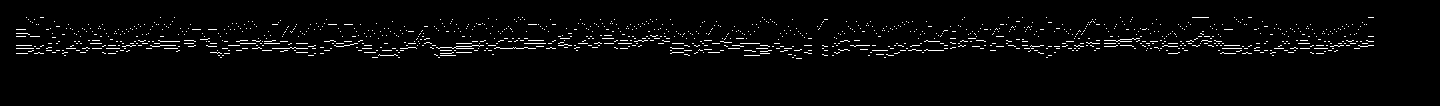

In [ ]:
classical_list = list(data_dir.glob('classical/*'))
PIL.Image.open(str(classical_list[0]))

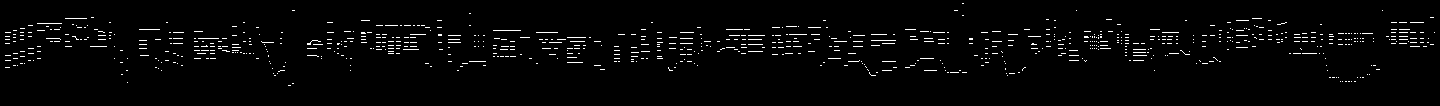

In [ ]:
jazz_list = list(data_dir.glob('jazz/*'))
PIL.Image.open(str(jazz_list[0]))

In [ ]:
content_image = np.asarray(PIL.Image.open(str(jazz_list[0])))
content_image = content_image[..., np.newaxis]
content_image = content_image[np.newaxis, ...]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
content_image = normalization_layer(content_image)
content_image.shape

TensorShape([1, 106, 1440, 1])

In [ ]:
batch_size = 32
img_height = 107
img_width = 720*2

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 530 files belonging to 2 classes.
Using 424 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 530 files belonging to 2 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['classical', 'jazz']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 107, 1440, 1)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train genre classifier model

We train a simple CNN to perform genre classification that will later be used as feature extractor for the style transfer

In [ ]:
num_classes = 2
inputs = tf.keras.Input(shape=(107, 720*2, 1), name='input')
x = layers.Conv1D(32, 5, activation='relu', name = 'block1_conv1', padding='same')(inputs)
x = layers.Conv1D(32, 5, activation='relu', name = 'block1_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool1')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block2_conv1', padding='same')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block2_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool2')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block3_conv1', padding='same')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block3_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool3')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block4_conv1', padding='same')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block4_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool4')(x)
x = layers.Flatten(name = 'flatten')(x)
x = layers.Dense(64, activation='relu', name = 'dense1')(x)
outputs = layers.Dense(num_classes, name = 'dense2')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="genre_classifier")

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
14/14 [==============================] - 5s 329ms/step - loss: 0.5451 - accuracy: 0.7358 - val_loss: 0.3818 - val_accuracy: 0.8585
Epoch 2/30
14/14 [==============================] - 4s 257ms/step - loss: 0.3625 - accuracy: 0.8679 - val_loss: 0.3269 - val_accuracy: 0.8679
Epoch 3/30
14/14 [==============================] - 4s 258ms/step - loss: 0.2295 - accuracy: 0.9127 - val_loss: 0.3290 - val_accuracy: 0.8491
Epoch 4/30
14/14 [==============================] - 4s 259ms/step - loss: 0.1760 - accuracy: 0.9316 - val_loss: 0.2927 - val_accuracy: 0.8774
Epoch 5/30
14/14 [==============================] - 4s 260ms/step - loss: 0.0977 - accuracy: 0.9599 - val_loss: 0.3376 - val_accuracy: 0.8868
Epoch 6/30
14/14 [==============================] - 4s 260ms/step - loss: 0.0268 - accuracy: 0.9906 - val_loss: 0.7722 - val_accuracy: 0.8113
Epoch 7/30
14/14 [==============================] - 4s 261ms/step - loss: 0.0830 - accuracy: 0.9670 - val_loss: 0.5637 - val_accuracy: 0.9057
Epoch 

In [ ]:
model.summary()

Model: "genre_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 107, 1440, 1)]    0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 107, 1440, 32)     192       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 107, 1440, 32)     5152      
_________________________________________________________________
avg_pool1 (AveragePooling2D) (None, 53, 720, 32)       0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 53, 720, 32)       3104      
_________________________________________________________________
block2_conv2 (Conv1D)        (None, 53, 720, 32)       3104      
_________________________________________________________________
avg_pool2 (AveragePooling2D) (None, 26, 360, 32)  

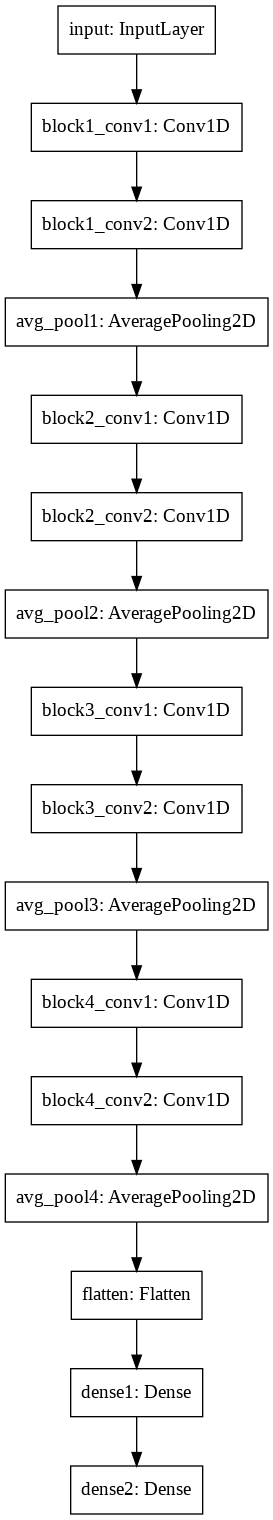

In [ ]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=False)

In [ ]:
print()
for layer in model.layers:
  print(layer.name)


input
block1_conv1
block1_conv2
avg_pool1
block2_conv1
block2_conv2
avg_pool2
block3_conv1
block3_conv2
avg_pool3
block4_conv1
block4_conv2
avg_pool4
flatten
dense1
dense2


### Define content and style layers

In [ ]:
content_layers = ['block4_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def model_layers(layer_names, model):
  """ Creates a vgg model that returns a list of intermediate output values."""
  model.trainable = False
  
  outputs = [model.get_layer(name).output for name in layer_names]

  style_model = tf.keras.Model([model.inputs], outputs)
  return style_model

### Style Image

We use a simple style image to test out the style transfer model. Here the style image represents a monotonic battle where one player gradually dominates the other. Style image can be modifed with relevant metrics to match the game context.

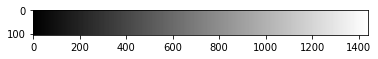

In [ ]:
from PIL import Image
import numpy as np

w, h = 720*2, 1
x = np.linspace(0.3, 0.9, w) # Use game evaluations here
# x = np.linspace(0, 8*np.pi*w, w) # Use game evaluations here
# x = np.sin(x)
# x = np.ones(w) # Use game evaluations here
style_image = np.tile(x, (w, 1))
style_image = style_image[:106, :]
plt.imshow(style_image, cmap='gray')
plt.show()

In [ ]:
style_image = style_image[..., np.newaxis]
style_image = style_image[np.newaxis, ...]
style_image.shape

(1, 106, 1440, 1)

In [ ]:
print(style_image.shape)
print(content_image.shape)

(1, 106, 1440, 1)
(1, 106, 1440, 1)


In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  # tensor = enhance_contrast(tensor)
  # tensor = binarize(tensor)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor[...,0], 'L')

### Simple superpostion

We use a simple superpositon of the two images as a baseline

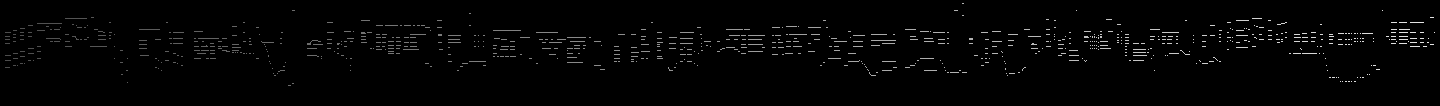

In [ ]:
comb_image = style_image*content_image
# plt.imshow(comb_image[0, ..., 0], cmap='gray')
# plt.show()
tensor_to_image(comb_image[0, ...])

In [ ]:
style_extractor = model_layers(style_layers, model)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 106, 1440, 32)
  min:  0.0
  max:  119.81703
  mean:  12.296399

block2_conv1
  shape:  (1, 53, 720, 32)
  min:  0.0
  max:  71.38981
  mean:  8.190309

block3_conv1
  shape:  (1, 26, 360, 32)
  min:  0.0
  max:  51.807053
  mean:  7.915393



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Define the style transfer model


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.model =  model_layers(style_layers + content_layers, model)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    # preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.model(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 32, 32)
    min:  0.0
    max:  307.62723
    mean:  11.338758

   block2_conv1
    shape:  (1, 32, 32)
    min:  0.0
    max:  65.96168
    mean:  2.0338087

   block3_conv1
    shape:  (1, 32, 32)
    min:  0.0
    max:  16.146461
    mean:  1.2849333

Contents:
   block4_conv2
    shape:  (1, 13, 180, 32)
    min:  0.0
    max:  13.841586
    mean:  0.2503317


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=5e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
def enhance_contrast(image):
  # Get brightness range - i.e. darkest and lightest pixels
  min=np.min(image)        # result=144
  max=np.max(image)        # result=216

  # Make a LUT (Look-Up Table) to translate image values
  LUT=np.zeros(256,dtype=np.uint8)
  LUT[min:max+1]=np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)
  return LUT[image]

In [ ]:
def binarize(img, threshold=150):
  binarized = 1.0 * (img > threshold)
  return binarized

### Run the style transfer model on a sample image

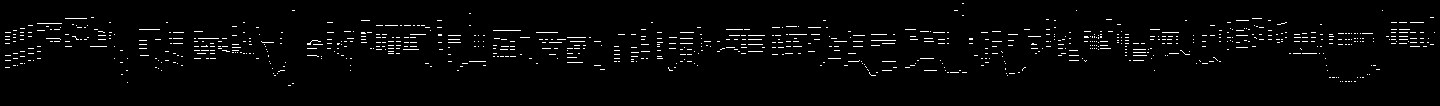

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

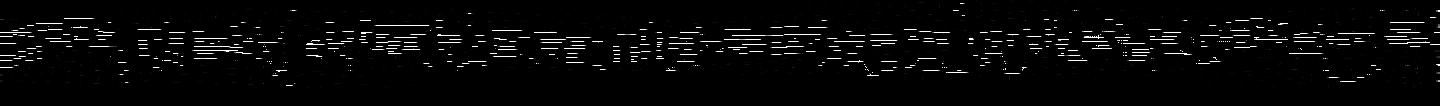

Train step: 1000
Total time: 8.0


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)
"""
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)
"""

'\ntry:\n  from google.colab import files\nexcept ImportError:\n   pass\nelse:\n  files.download(file_name)\n'

In [ ]:
from pathlib import Path

### Run superposition on all the images

In [ ]:
Path("out_superposed/classical/").mkdir(parents=True, exist_ok=True)
for img_path in classical_list:
  content_image = np.asarray(PIL.Image.open(str(img_path)))
  content_image = content_image[..., np.newaxis]
  content_image = content_image[np.newaxis, ...]
  normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  content_image = normalization_layer(content_image)
  comb_image = style_image*content_image
  tensor_to_image(comb_image[0, ...]).save("out_superposed/classical/" + os.path.split(img_path)[1])
  

In [ ]:
Path("out_superposed/jazz/").mkdir(parents=True, exist_ok=True)
for img_path in jazz_list:
  content_image = np.asarray(PIL.Image.open(str(img_path)))
  content_image = content_image[..., np.newaxis]
  content_image = content_image[np.newaxis, ...]
  normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  content_image = normalization_layer(content_image)
  comb_image = style_image*content_image
  tensor_to_image(comb_image[0, ...]).save("out_superposed/jazz/" + os.path.split(img_path)[1])

### Run style transfer on all the images

In [ ]:
i = 0
Path("out_style_transferred/classical/").mkdir(parents=True, exist_ok=True)
for img_path in classical_list:
  content_image = np.asarray(PIL.Image.open(str(img_path)))
  content_image = content_image[..., np.newaxis]
  content_image = content_image[np.newaxis, ...]
  normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  content_image = normalization_layer(content_image)
  extractor = StyleContentModel(style_layers, content_layers)

  results = extractor(tf.constant(content_image))
  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']
  image = tf.Variable(content_image)
  epochs = 10
  steps_per_epoch = 100

  @tf.function()
  def train_step(image):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
      # print(".", end='')
    # display.clear_output(wait=True)
    # display.display(tensor_to_image(image))
    # print("Train step: {}".format(step))
  tensor_to_image(image).save("out_style_transferred/classical/" + os.path.split(img_path)[1])
  i += 1
  if i >= 10: # Only 10 sample clips to reduce the execution time. Remove this to get results for the entire dataset
    break


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [ ]:
i = 0
Path("out_style_transferred/jazz/").mkdir(parents=True, exist_ok=True)
for img_path in jazz_list:
  content_image = np.asarray(PIL.Image.open(str(img_path)))
  content_image = content_image[..., np.newaxis]
  content_image = content_image[np.newaxis, ...]
  normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  content_image = normalization_layer(content_image)
  extractor = StyleContentModel(style_layers, content_layers)

  results = extractor(tf.constant(content_image))
  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']
  image = tf.Variable(content_image)
  epochs = 10
  steps_per_epoch = 100

  @tf.function()
  def train_step(image):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
      # print(".", end='')
    # display.clear_output(wait=True)
    # display.display(tensor_to_image(image))
    # print("Train step: {}".format(step))
  tensor_to_image(image).save("out_style_transferred/jazz/" + os.path.split(img_path)[1])
  i += 1
  if i >= 10:
    break


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [ ]:
!zip -r out_style_transferred.zip /content/out_style_transferred

  adding: content/out_style_transferred/ (stored 0%)
  adding: content/out_style_transferred/jazz/ (stored 0%)
  adding: content/out_style_transferred/jazz/BlueTrain_Piano_0.png (deflated 4%)
  adding: content/out_style_transferred/jazz/Aliceinw_Piano_0.png (deflated 2%)
  adding: content/out_style_transferred/jazz/DaysOf_Piano_0.png (deflated 1%)
  adding: content/out_style_transferred/jazz/Danny Boy_Piano_0.png (deflated 1%)
  adding: content/out_style_transferred/jazz/Dreamsville_Piano_0.png (deflated 1%)
  adding: content/out_style_transferred/jazz/AllTheThings V2_Piano_0.png (deflated 1%)
  adding: content/out_style_transferred/jazz/Dannyboy_Piano_0.png (deflated 1%)
  adding: content/out_style_transferred/jazz/Bymyself_Piano_0.png (deflated 1%)
  adding: content/out_style_transferred/jazz/Chameleon_Piano_0.png (deflated 3%)
  adding: content/out_style_transferred/jazz/Autumn In NY_Piano_0.png (deflated 0%)
  adding: content/out_style_transferred/classical/ (stored 0%)
  adding: c

In [ ]:
!zip -r out_superposed.zip /content/out_superposed/

  adding: content/out_superposed/ (stored 0%)
  adding: content/out_superposed/jazz/ (stored 0%)
  adding: content/out_superposed/jazz/afine-1_Piano_0.png (deflated 2%)
  adding: content/out_superposed/jazz/youtookadvantageofme_Piano_0.png (deflated 2%)
  adding: content/out_superposed/jazz/peanutsg_Piano_0.png (deflated 5%)
  adding: content/out_superposed/jazz/HaveUMMsJ_Piano_0.png (deflated 2%)
  adding: content/out_superposed/jazz/Thingsaintwhattheyusedtobe_Piano_0.png (deflated 2%)
  adding: content/out_superposed/jazz/Isfahan (Elf)_Piano_0.png (deflated 2%)
  adding: content/out_superposed/jazz/The End of a Love Affair_Piano_0.png (deflated 1%)
  adding: content/out_superposed/jazz/simplelife_Piano_0.png (deflated 1%)
  adding: content/out_superposed/jazz/Yesterdays1_Piano_0.png (deflated 1%)
  adding: content/out_superposed/jazz/sushi_Piano_0.png (deflated 2%)
  adding: content/out_superposed/jazz/My Romance_Piano_0.png (deflated 1%)
  adding: content/out_superposed/jazz/Isn_t_i